In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [22]:
bit_data=pd.read_csv("Datasets/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")

In [25]:
bit_data["date"]=pd.to_datetime(bit_data["Timestamp"],unit="s").dt.date
group=bit_data.groupby("date")
data=group["Close"].mean()

In [30]:
close_train=data.iloc[:len(data)-50]
close_test=data.iloc[len(close_train):]

In [31]:
close_train=np.array(close_train)
close_train=close_train.reshape(close_train.shape[0],1)
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
close_scaled=scaler.fit_transform(close_train)

In [32]:
timestep=50
x_train=[]
y_train=[]

for i in range(timestep,close_scaled.shape[0]):
    x_train.append(close_scaled[i-timestep:i,0])
    y_train.append(close_scaled[i,0])

x_train,y_train=np.array(x_train),np.array(y_train)
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1) #reshaped for RNN
print("x_train shape= ",x_train.shape)
print("y_train shape= ",y_train.shape)

x_train shape=  (3276, 50, 1)
y_train shape=  (3276,)


In [34]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout,Flatten

In [35]:
regressor=Sequential()
#first RNN layer
regressor.add(SimpleRNN(128,activation="relu",return_sequences=True,input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(0.25))
#second RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#third RNN layer
regressor.add(SimpleRNN(512,activation="relu",return_sequences=True))
regressor.add(Dropout(0.35))
#fourth RNN layer
regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#fifth RNN layer
regressor.add(SimpleRNN(128,activation="relu",return_sequences=True))
regressor.add(Dropout(0.25))
#convert the matrix to 1-line
regressor.add(Flatten())
#output layer
regressor.add(Dense(1))

regressor.compile(optimizer="adam",loss="mean_squared_error")
regressor.fit(x_train,y_train,epochs=100,batch_size=64)

Epoch 1/100
52/52 [==============================] - 47s 456ms/step - loss: 0.0104
Epoch 2/100
52/52 [==============================] - 37s 727ms/step - loss: 0.0018
Epoch 3/100
52/52 [==============================] - 39s 753ms/step - loss: 8.0641e-04
Epoch 4/100
52/52 [==============================] - 41s 781ms/step - loss: 6.2528e-04
Epoch 5/100
52/52 [==============================] - 40s 775ms/step - loss: 5.7402e-04
Epoch 6/100
52/52 [==============================] - 39s 756ms/step - loss: 7.6455e-04
Epoch 7/100
52/52 [==============================] - 40s 773ms/step - loss: 5.4194e-04
Epoch 8/100
52/52 [==============================] - 40s 761ms/step - loss: 6.7710e-04
Epoch 9/100
52/52 [==============================] - 39s 753ms/step - loss: 4.8053e-04
Epoch 10/100
52/52 [==============================] - 40s 766ms/step - loss: 3.4502e-04
Epoch 11/100
52/52 [==============================] - 40s 769ms/step - loss: 3.8474e-04
Epoch 12/100
52/52 [=============================

In [36]:
inputs=data[len(data)-len(close_test)-timestep:]
inputs=inputs.values.reshape(-1,1)
inputs=scaler.transform(inputs)

In [37]:
x_test=[]
for i in range(timestep,inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])
x_test=np.array(x_test)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [38]:
predicted_data=regressor.predict(x_test)
predicted_data=scaler.inverse_transform(predicted_data)

In [39]:
data_test=np.array(close_test)
data_test=data_test.reshape(len(data_test),1)

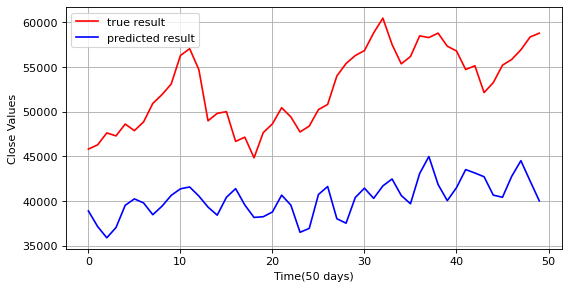

In [40]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test,color="r",label="true result")
plt.plot(predicted_data,color="b",label="predicted result")
plt.legend()
plt.xlabel("Time(50 days)")
plt.ylabel("Close Values")
plt.grid(True)
plt.show()